In [1]:
import numpy as np
import scipy
import time
import heapq
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from os import listdir, walk
from os.path import isfile, join
from sortedcontainers import SortedList
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Preparation
#### id -> data

In [2]:
init_point = 1416726000
pattern = '%Y-%m-%d %H:%M:%S'
to_int = lambda x: int(time.mktime(time.strptime(x, pattern)))
to_str = lambda x: time.strftime(pattern, time.gmtime(init_point+500*x))

# csv's

root = './data_yahoo/'

for d in [f for f in listdir(root) if not isfile(f) and not '.' in f ]:
    for f in listdir(root+d):
        if f.startswith('.'):
            continue
        path = root+d+'/'+f
        df = pd.read_csv(path)
        df['timestamp'] = df['timestamp'].map(to_str)
        df.to_csv(root+d+'/'+f, index=False)
        
root_l = './labels/yahoo_labels.json'
root_w = './labels/yahoo_windows.json'

labels = json.load(open(root_l,'r'))
windows = json.load(open(root_w,'r'))


for k,v in labels.items():
    labels[k] = [to_str(x) for x in v]
    
for k,v in windows.items():
    new_windows = []
    for w in v:
        new_windows.append([to_str(x) for x in w])
    windows[k] = new_windows

keys = list(labels.keys())
for k in keys:
    if k.startswith('A1'):
        continue        
    try:
        ident = int(k[-6:-4])
        if ident == 10 or ident == 11:
            continue
        labels.pop(k)
        windows.pop(k)
    except Exception as e:
        continue
        
with open(root_l, 'w') as outfile:
    json.dump(labels, outfile)
with open(root_w, 'w') as outfile:
    json.dump(windows, outfile)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

### Lens of corpus

In [80]:
root = 'data/'
count_nab = []
for d in [d for d in listdir(root) if '.' not in d]:
    for f in listdir(root+d):
        if not f.startswith('.'):
            count_nab.append(len(pd.read_csv(root+d+'/'+f)))

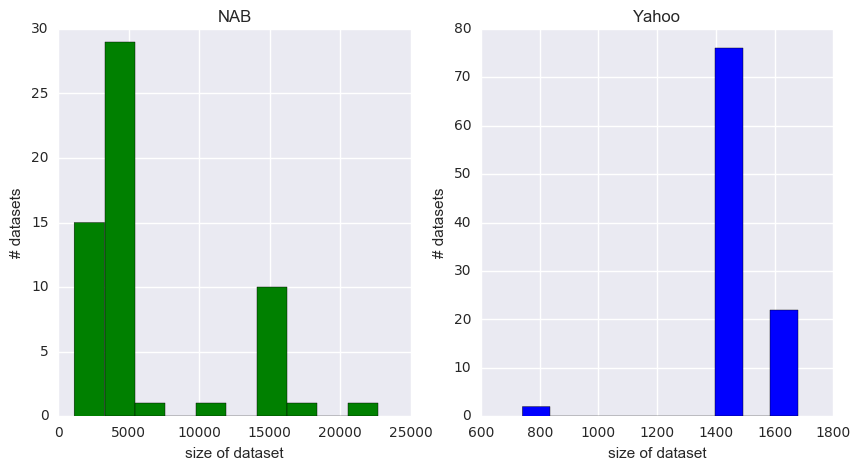

In [88]:
import seaborn as sns
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.hist(count_nab, color='g')
plt.title('NAB')
plt.xlabel('size of dataset')
plt.ylabel('# datasets')
plt.subplot(1,2,2)
plt.hist(count_yahoo, color='b')
plt.xlabel('size of dataset')
plt.ylabel('# datasets')
plt.title('Yahoo');

# TIMING

In [107]:
res = []

In [108]:
times = pd.read_csv('timing.csv')
cols = times.columns
res.append(sum(times)[1])

In [109]:
print(cols)
diz = sum(times)[0]/1000
np.mean(res), np.mean(res)/diz

Index(['loopcad', ' data_yahoo'], dtype='object')


(792.00507000000016, 5.371091708091174)

In [115]:
(np.mean(res)+700)/diz, np.mean(res)+700

(10.118238333887168, 1492.0050700000002)

In [60]:
np.mean(res), np.mean(res)/diz
res

[977.31277500000022, 990.50203599999986]

# Scoring

In [127]:
class KnnDetector:
    def __init__(self, pr, d_max, d_min, k, dim):
        self.buf = []
        self.training = []
        self.record_count = 0
        
        self.sigmas = []
        self.rang = d_max - d_min
        self.probationaryPeriod = pr
        # Hyperparams
        self.k = k
        self.dim = dim
                
        self.sigma = np.diag(np.ones(self.dim))

    def metric(self, a, b):
        diff = a - np.array(b)
        return np.dot(np.dot(diff, self.sigma), diff.T)**0.5

    def get_NN_dist(self, item):
        dists = []
        for x in self.training[:-1]:
            dist = self.metric(x, item)
            if len(dists) < self.k:
                dists.append(dist)
            else:
                i = np.argmax(dists)
                if dists[i] > dist:
                    dists[i] = dist
        return sum(dists) / (self.rang * self.k * self.dim**0.5)  
    
    def update_sigma(self):
        try:
            X = self.training - np.mean(self.training, axis=0)
            self.sigma = np.linalg.inv(np.dot(X.T, X))
            self.sigma /= np.linalg.norm(self.sigma, axis=0)
        except np.linalg.linalg.LinAlgError:
            print('Singular Matrix at record', self.record_count)

    def handleRecord(self, inputData):
        """
        inputRow = [inputData["timestamp"], inputData["value"]]
        """
        self.buf.append(inputData["value"])

        if len(self.buf) < self.dim:
            return [0.0]
        else:
            new_item = self.buf[-self.dim:]
            self.record_count += 1
            if self.record_count < self.probationaryPeriod - self.dim:
                self.training.append(new_item)
                return [0.0]
            else:
                self.training.append(new_item)
                
                self.update_sigma()
                
                return [self.get_NN_dist(new_item)]


1422 ../../data/data_yahoo/A1_yahoo/real_20.csv 3.85
Complete 0 records
Complete 100 records
Complete 200 records
Complete 300 records
Complete 400 records
Complete 500 records
Complete 600 records
Complete 700 records
Complete 800 records
Complete 900 records
Complete 1000 records
Complete 1100 records
Complete 1200 records
Complete 1300 records
Complete 1400 records
--- 19.109575033187866 seconds ---


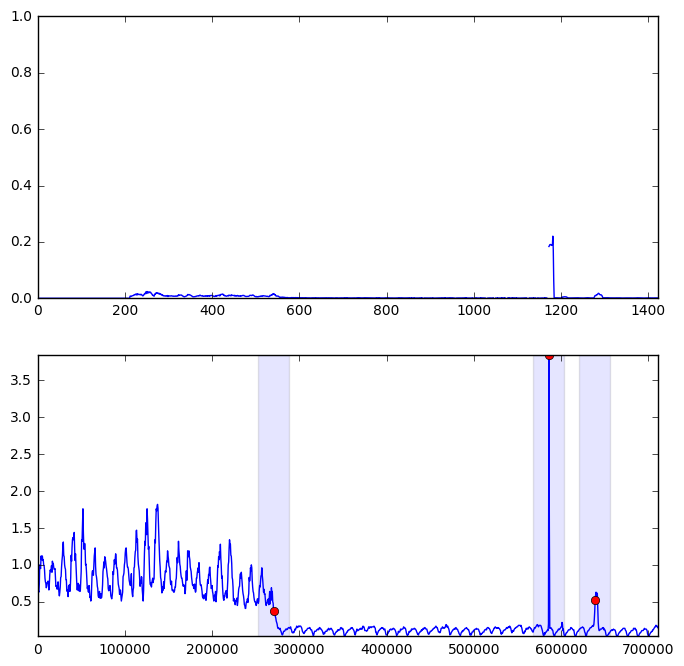

In [128]:
is_nab = 0

root = '../../data/data_nab' if is_nab else '../../data/data_yahoo/'
root_l = '../../data/labels/combined_labels.json' if is_nab else '../../data/labels/yahoo_labels.json'
root_w = '../../data/labels/combined_windows.json' if is_nab else '../../data/labels/yahoo_windows.json'

labels = json.load(open(root_l,'r'))
windows = json.load(open(root_w,'r'))


pattern = '%Y-%m-%d %H:%M:%S'
to_int = lambda x: int(time.mktime(time.strptime(x, pattern)))

def game(path,i,pr=None):
    files = [f for f in listdir(root+path) if not f.startswith('.')]
    name = path+files[i]
    df = pd.read_csv(root+name)
    print(len(df), root+name, max(df['value']))
    anomalyScore = []
    detector = None
    if pr is None:
        detector = KnnDetector(15*len(df)/100, max(df['value']), min(df['value']), 5, 11)
    else:
        detector = KnnDetector(pr, max(df['value']), min(df['value']), 5, 11)
    
    start_time = time.time()
    for i,x in enumerate(df.values):
        
        anomalyScore.append(detector.handleRecord({'value':x[1]})) 
        if i % 100 == 0:
#         if (i % 100 == 0 and i < pr) or (i % 10 and i > pr):
            print('Complete', i, 'records')
    print("--- %s seconds ---" % (time.time() - start_time))  
#     return anomalyScore, detector
    fig = plt.figure(figsize=(8,8))
    csv = df
    x = [to_int(tm)- to_int(csv['timestamp'][0]) for tm in list(csv['timestamp'])]
    y = list(csv['value'])

    ax = fig.add_subplot(2, 1, 1)
    ax.plot(anomalyScore)
    ax.axis('tight')
    plt.ylim((0,1))
    ax = fig.add_subplot(2, 1, 2)
    ax.plot(x, y)
    ax.axis('tight')
    # plot anomaly window
    for wind in windows[name]:
        begin = to_int(wind[0].split('.')[0]) - to_int(csv['timestamp'][0])
        end = to_int(wind[1].split('.')[0])-to_int(csv['timestamp'][0])
        ax.add_patch(patches.Rectangle((begin, min(y)), end-begin, max(y)-min(y),alpha=0.1))
    # plot anomalies
    index = [list(csv['timestamp']).index(lab) for lab in labels[name]]
    ax.plot([x[j] for j in index], [y[j] for j in index], 'or')
    
    return anomalyScore, detector

#  'artificialNoAnomaly', 600
#  'artificialWithAnomaly', 600
#  'realAdExchange', 240
#  'realAWSCloudwatch', 600,
#  'realKnownCause', iio,hold = 200, ec2=600, other=750
#  'realTraffic', 300, 7578 = 170
#  'realTweets', 750

#  'A1_yahoo'
#  'A2_yahoo'
#  'A3_yahoo'
#  'A4_yahoo'


path = "A1_yahoo/"
res = game(path,12)

array([], dtype=float64)

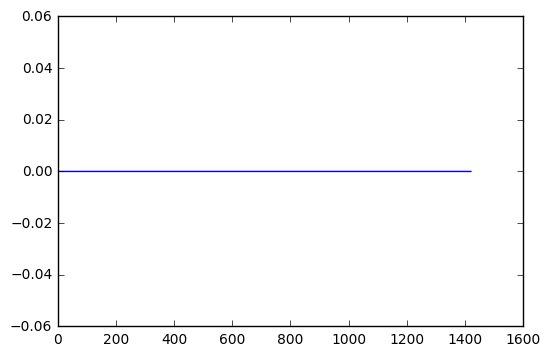

In [129]:
border = 0.995
plt.plot([x[0] if x[0] > border else 0 for x in res[0]])
np.array(res[0])[np.array(res[0]) > border]

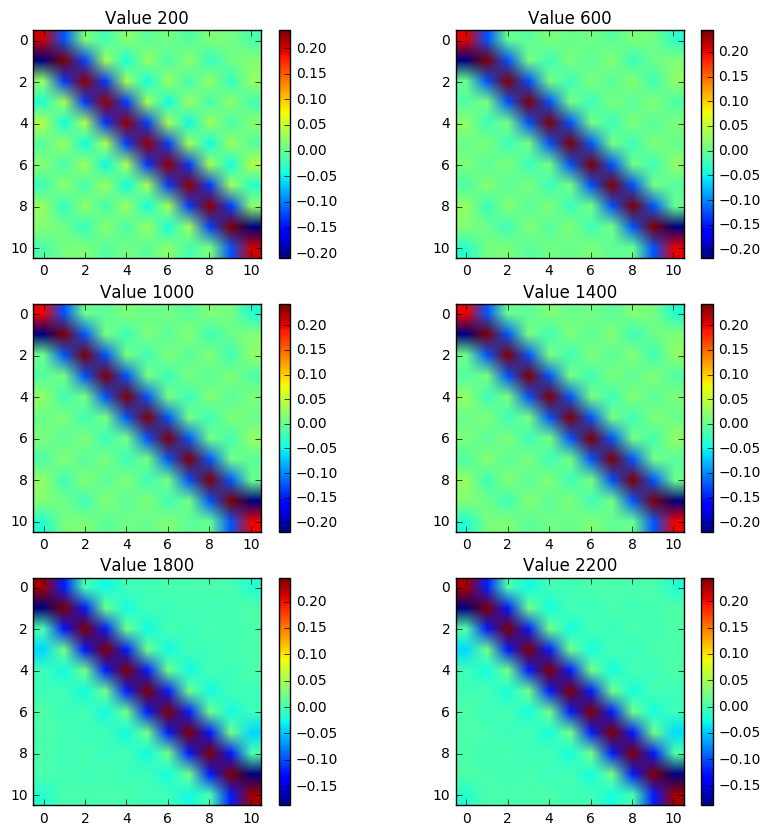

In [130]:
plt.figure(figsize=(10,10))
for i in np.arange(1,12,2):
    plt.subplot(3,2,(i+1)/2)
    plt.title('Value %d' % (i*200))
    plt.imshow((res[1].sigmas[i])/ np.linalg.norm((res[1].sigmas[i])))
    plt.colorbar()

# Dolan-Moore

In [4]:
listdir('results')

['.DS_Store',
 'bayesChangePt',
 'contextOSE',
 'expose',
 'final_results.json',
 'knn',
 'knncad',
 'lof',
 'lofcad',
 'loop',
 'loopcad',
 'null',
 'numenta',
 'numentaTM',
 'random',
 'README.md',
 'relativeEntropy',
 'skyline',
 'twitterADVec',
 'windowedGaussian']

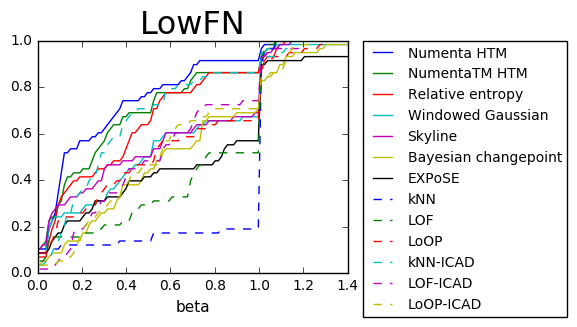

In [321]:
detectors = ['numenta','numentaTM','relativeEntropy','windowedGaussian','skyline','bayesChangePt','expose',
             'knn','lof','loop','knncad','lofcad','loopcad']
detectors_names = ['Numenta HTM','NumentaTM HTM','Relative entropy','Windowed Gaussian','Skyline',
                   'Bayesian changepoint','EXPoSE','kNN','LOF','LoOP','kNN-ICAD','LOF-ICAD','LoOP-ICAD']
files = ['_standard_scores.csv', '_reward_low_FP_rate_scores.csv', '_reward_low_FN_rate_scores.csv']
files_names = ['Standart', 'LowFP', 'LowFN']
f=2

root = ['results/', 'labels/combined_labels.json']
# root = ['result_yahoo/', 'labels/yahoo_labels.json']

values = []

## Separate
for det in detectors:
    values.append(list(pd.read_csv(root[0]+det+'/'+det+files[f]).sort_values('File')['Score'][:-1]))
null = np.array(list(pd.read_csv(root[0]+'null/null'+files[f]).sort_values('File')['Score'][:-1]))
with open(root[1], 'r') as file:
    js = json.load(file)
perfect = np.array([len(js[k]) for k in sorted(js)])

denom = perfect - null
denom[denom==0]=1

new_values = []
for v in values:
    num = v - null
    denom = perfect - null
    res = num/denom
    res[np.logical_and(num == 0, denom == 0)] = 1
    res[np.logical_or(res == inf, res == -inf)] = 0
    new_values.append(res)
values = np.array(new_values)

# # ## Total
# for det in detectors:
#     values.append(hstack((list(pd.read_csv('results/'+det+'/'+det+files[f])['Score'][:-1]), 
#        list(pd.read_csv('result_yahoo/'+det+'/'+det+files[f])['Score'][:-1]))))

# dolan_moore = []
# x = np.linspace(0.,1.5, 101)
# for b in x:
#     dolan_moore.append([np.mean(values[i] >= 1./b*np.max(values, axis=0)) for i in range(len(detectors))])
# dolan_moore = np.array(dolan_moore).T
# for i in range(7):
#     plt.plot(x, dolan_moore[i], '-')
# for i in range(6):
#     plt.plot(x, dolan_moore[7+i], '--')
# plt.title(files_names[f], fontsize=23)
# plt.xlabel('beta', fontsize=15)
# # plt.gca().set_xlim(plt.gca().get_xlim()[::-1])

plt.figure(figsize=(4,3))

dolan_moore = []
# x = np.logspace(-2,1, 101)
x = np.linspace(0.01,1.4,101)
for b in x:
    dolan_moore.append([sum(1-values[i] <= b)/len(values[i]) for i in range(len(detectors))])
dolan_moore = np.array(dolan_moore).T

for i in range(7):
    plt.plot(x, dolan_moore[i], '-')
for i in range(6):
    plt.plot(x, dolan_moore[7+i], '--')
plt.title(files_names[f], fontsize=23)
plt.xlabel('beta', fontsize=11)
# plt.gca().set_xlim(plt.gca().get_xlim()[::-1])
# plt.xscale('log')

if f == 2:
    plt.legend(detectors_names, bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0., fontsize=10)
if f == 0:
    plt.ylabel('ratio of tests which error below beta', fontsize=11)

In [132]:
np.linspace(0,1,11)

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

In [141]:
stats = {'a':100, 0.5:1000, 'ss':2, 0.4:1000, 0.6:1000}
max(stats.iterkeys(), key=stats.get)

AttributeError: 'dict' object has no attribute 'iterkeys'

In [136]:
np.round(10.123123123123, 4)

10.123100000000001

In [222]:
len(listdir('data/artificialWithAnomaly/'))+len(listdir('data/artificialNoAnomaly/'))

11

In [224]:
count = 0

path = listdir('data/artificialWithAnomaly/')

In [290]:
art = [x for x in listdir('data_yahoo') if '.' not in x][1:]
real = [x for x in listdir('data_yahoo') if '.' not in x][:1]
with open('labels/yahoo_labels.json', 'r') as f:
    js = json.load(f)

In [299]:
lens = []
preroot = 'data_yahoo/'
for root in real:
    root += '/'
    for csv in listdir(preroot+root):
        if not csv.startswith('.'):
            lens.append(len(js[root+csv]))
        

In [301]:
min(lens), np.mean(lens), max(lens), sum(lens)

(0, 2.1343283582089554, 5, 143)

In [296]:
art, real

(['A2_yahoo', 'A3_yahoo', 'A4_yahoo'], ['A1_yahoo'])

In [292]:


js#, [len(js[k]) for k in sorted(js)]

{'A1_yahoo/real_1.csv': ['2014-11-30 07:36:40'],
 'A1_yahoo/real_10.csv': ['2014-12-01 13:03:20'],
 'A1_yahoo/real_11.csv': ['2014-12-01 11:31:40'],
 'A1_yahoo/real_12.csv': ['2014-12-01 14:01:40'],
 'A1_yahoo/real_13.csv': ['2014-11-28 22:08:20', '2014-12-01 13:45:00'],
 'A1_yahoo/real_14.csv': ['2014-11-25 07:20:00'],
 'A1_yahoo/real_15.csv': ['2014-11-28 22:08:20', '2014-12-01 13:45:00'],
 'A1_yahoo/real_16.csv': ['2014-12-01 02:21:40'],
 'A1_yahoo/real_17.csv': ['2014-11-27 17:40:00',
  '2014-11-28 03:40:00',
  '2014-11-29 03:25:00',
  '2014-12-01 01:56:40',
  '2014-12-01 11:56:40'],
 'A1_yahoo/real_18.csv': ['2014-11-25 17:28:20'],
 'A1_yahoo/real_19.csv': ['2014-11-27 17:56:40',
  '2014-11-28 03:56:40',
  '2014-11-29 03:16:40',
  '2014-12-01 01:56:40',
  '2014-12-01 11:56:40'],
 'A1_yahoo/real_2.csv': ['2014-12-01 03:53:20', '2014-12-01 13:53:20'],
 'A1_yahoo/real_20.csv': ['2014-11-26 10:08:20',
  '2014-11-30 01:46:40',
  '2014-11-30 16:30:00'],
 'A1_yahoo/real_21.csv': ['2014-1